In [11]:
import shapely as shapely
from shapely.ops import split,substring
from shapely.geometry import Point,mapping, LineString, Polygon, MultiPoint
import numpy as np
import rasterio
from rasterio import plot, mask
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
from math import atan, degrees

In [2]:
OS_National_Grids = gpd.read_file(os.path.join('OS-British-National-Grids-main','OS-British-National-Grids-main','os_bng_grids.gpkg'),layer='1km_grid')

In [12]:
study_area_shapely = OS_National_Grids[OS_National_Grids['tile_name'] == "SX7677"].geometry.cascaded_union

In [4]:
Haytor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(os.path.join('OS Elevation','Download_Haytor_Elevation_2035988','terrain-5-dtm_4600215','sx','SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation,[study_area], filled=False, crop=False)

network_links = gpd.read_file(os.path.join('Study_area','SX7677','network_links.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area','SX7677','network_nodes.geojson'))


##  3. OS Detailed Path Network

In [5]:
path_network = gpd.read_file(os.path.join('Detailed-Path-Network', 'DARTMOOR NATIONAL PARK.gml'),layer='RouteLink')

In [6]:
OSDPN= path_network.intersection(study_area_shapely)
OSDPN= OSDPN[~OSDPN.is_empty]
OSDPN_gpd = gpd.GeoDataFrame(geometry=OSDPN)

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [7]:
OSDPN_gpd_not_working = OSDPN_gpd.loc[[5659,16489,6637,14642,16558,]]

### Getting the points that intersect between AL and OSPN

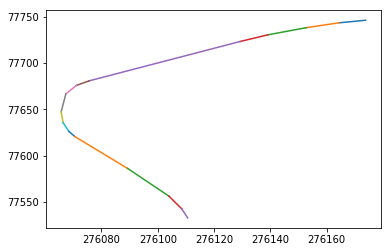

In [8]:
row1 =OSDPN_gpd.iloc[12]
links = []
line_coords = MultiPoint([Point(points) for points in row1.geometry.coords])
result = split(row1.geometry, line_coords)
for linestring in result:
    plt.plot(*linestring.xy)

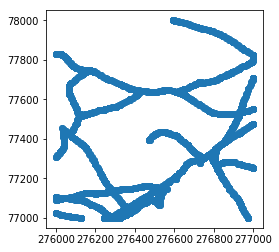

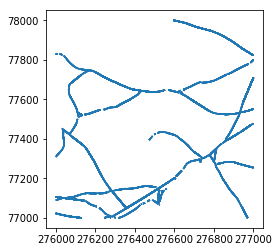

In [19]:
geom_points = []
geom_lines = []
start_node = []
end_node = []
height = []
length = []
angles = []
climb_time_forward = []
climb_time_backward = []
dpn = []
fid = []
count = 1
for index1,row1 in OSDPN_gpd.iterrows():
    if row1.geometry.geom_type != 'MultiLineString':
        line_coords = MultiPoint([Point(points) for points in row1.geometry.coords])
        result = split(row1.geometry, line_coords)
        for linestring in result:
            intersects = {}
            local_height = []
            previous_point = 0
            for index2, row2 in network_links.iterrows():
                intersecting_point = linestring.intersection(row2.geometry)
                if not intersecting_point.is_empty:
                    if intersecting_point != previous_point:
                        network_node = [(Point(row2['geometry'].bounds[0],row2['geometry'].bounds[1])),(Point(row2['geometry'].bounds[2],row2['geometry'].bounds[3]))]
                        if intersecting_point.geom_type != 'MultiPoint':
                            start_point = Point(linestring.coords[0])
                            intersects[count]= start_point
                            geom_points.append(start_point)
                            height.append(start_point.z)
                            local_height.append(start_point.z)
                            start_point_fid = 'dpn_' + str(count)
                            fid.append(start_point_fid)
                            count = count + 1

                            intersects[count]= intersecting_point
                            geom_points.append(intersecting_point)
                            local_height.append(intersecting_point.z)
                            height.append(intersecting_point.z)
                            intersecting_point_fid = 'dpn_' + str(count)
                            fid.append(intersecting_point_fid)

                            count = count + 1

                            end_point = Point(linestring.coords[-1])
                            intersects[count]= end_point
                            geom_points.append(end_point)
                            local_height.append(end_point.z)
                            height.append(end_point.z)
                            start_point_fid = 'dpn_' + str(count)
                            fid.append(start_point_fid)
                            count = count + 1

                            points = MultiPoint(list(intersects.values()))
                            points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
                            line_2d = shapely.wkb.loads(shapely.wkb.dumps(linestring, output_dimension=2))
                            intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
                            intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
                            #adding the points to the linestring
                            line_coords = MultiPoint([Point(points) for points in line_2d.coords])
                            union = points_2d.union(line_coords)
                            # converting points to linestring
                            line = LineString(union)
                            # Splitting the line based on where intersections
                            splitted = split(line,points_2d)
                            for link in splitted:

                                # get start and end node
                                start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
                                end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
                                start_node.append('dpn_' + str(start_point))
                                end_node.append( 'dpn_' + str(end_point))

                                # get the reverse for backward direction
                                start_node.append( 'dpn_' + str(end_point))
                                end_node.append('dpn_' + str(start_point))

                                # get line geometry
                                geom_lines.append(link)
                                reverse_link = substring(link,link.length,0)
                                geom_lines.append(reverse_link)

                                # length
                                length.append(link.length)
                                length.append(link.length)

                                # get angle of elevation change and climb time
                                start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
                                # print(start_height)
                                end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

                                # print(end_height)
                                if start_height_forward > end_height_forward:
                                    change_height = start_height_forward - end_height_forward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_forward - start_height_forward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / link.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(1)

                                if start_height_backward > end_height_backward:
                                    change_height = start_height_backward - end_height_backward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_backward - start_height_backward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / link.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(1)
                        else:
                            for pt in intersecting_point:
                                start_point = Point(linestring.coords[0])
                                intersects[count]= start_point
                                geom_points.append(start_point)
                                height.append(start_point.z)
                                local_height.append(start_point.z)
                                start_point_fid = 'dpn_' + str(count)
                                fid.append(start_point_fid)
                                count = count + 1

                                intersects[count]= pt
                                geom_points.append(pt)
                                local_height.append(pt.z)
                                height.append(pt.z)
                                intersecting_point_fid = 'dpn_' + str(count)
                                fid.append(intersecting_point_fid)

                                count = count + 1

                                end_point = Point(linestring.coords[-1])
                                intersects[count]= end_point
                                geom_points.append(end_point)
                                local_height.append(end_point.z)
                                height.append(end_point.z)
                                start_point_fid = 'dpn_' + str(count)
                                fid.append(start_point_fid)
                                count = count + 1

                                points = MultiPoint(list(intersects.values()))
                                points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
                                line_2d = shapely.wkb.loads(shapely.wkb.dumps(linestring, output_dimension=2))
                                intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
                                intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
                                #adding the points to the linestring
                                line_coords = MultiPoint([Point(points) for points in line_2d.coords])
                                union = points_2d.union(line_coords)
                                # converting points to linestring
                                line = LineString(union)
                                # Splitting the line based on where intersections
                                splitted = split(line,points_2d)
                                for link in splitted:

                                    # get start and end node
                                    start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
                                    end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
                                    start_node.append('dpn_' + str(start_point))
                                    end_node.append( 'dpn_' + str(end_point))

                                    # get the reverse for backward direction
                                    start_node.append( 'dpn_' + str(end_point))
                                    end_node.append('dpn_' + str(start_point))

                                    # get line geometry
                                    geom_lines.append(link)
                                    reverse_link = substring(link,link.length,0)
                                    geom_lines.append(reverse_link)

                                    # length
                                    length.append(link.length)
                                    length.append(link.length)

                                    # get angle of elevation change and climb time
                                    start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
                                    # print(start_height)
                                    end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

                                    # print(end_height)
                                    if start_height_forward > end_height_forward:
                                        change_height = start_height_forward - end_height_forward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_forward - start_height_forward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / link.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(1)

                                    if start_height_backward > end_height_backward:
                                        change_height = start_height_backward - end_height_backward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_backward - start_height_backward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / link.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(1)
    else:
        for single_linestring in row1.geometry:
            line_coords = MultiPoint([Point(points) for points in single_linestring.coords])
            result = split(single_linestring, line_coords)
            for linestring in result:
                intersects = {}
                local_height = []
                previous_point = 0
                for index2, row2 in network_links.iterrows():
                    intersecting_point = linestring.intersection(row2.geometry)
                    if not intersecting_point.is_empty:
                        if intersecting_point != previous_point:
                            network_node = [(Point(row2['geometry'].bounds[0],row2['geometry'].bounds[1])),(Point(row2['geometry'].bounds[2],row2['geometry'].bounds[3]))]
                            if intersecting_point.geom_type != 'MultiPoint':
                                start_point = Point(linestring.coords[0])
                                intersects[count]= start_point
                                geom_points.append(start_point)
                                height.append(start_point.z)
                                local_height.append(start_point.z)
                                start_point_fid = 'dpn_' + str(count)
                                fid.append(start_point_fid)
                                count = count + 1

                                intersects[count]= intersecting_point
                                geom_points.append(intersecting_point)
                                local_height.append(intersecting_point.z)
                                height.append(intersecting_point.z)
                                intersecting_point_fid = 'dpn_' + str(count)
                                fid.append(intersecting_point_fid)

                                count = count + 1

                                end_point = Point(linestring.coords[-1])
                                intersects[count]= end_point
                                geom_points.append(end_point)
                                local_height.append(end_point.z)
                                height.append(end_point.z)
                                start_point_fid = 'dpn_' + str(count)
                                fid.append(start_point_fid)
                                count = count + 1

                                points = MultiPoint(list(intersects.values()))
                                points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
                                line_2d = shapely.wkb.loads(shapely.wkb.dumps(linestring, output_dimension=2))
                                intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
                                intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
                                #adding the points to the linestring
                                line_coords = MultiPoint([Point(points) for points in line_2d.coords])
                                union = points_2d.union(line_coords)
                                # converting points to linestring
                                line = LineString(union)
                                # Splitting the line based on where intersections
                                splitted = split(line,points_2d)
                                for link in splitted:

                                    # get start and end node
                                    start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
                                    end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
                                    start_node.append('dpn_' + str(start_point))
                                    end_node.append( 'dpn_' + str(end_point))

                                    # get the reverse for backward direction
                                    start_node.append( 'dpn_' + str(end_point))
                                    end_node.append('dpn_' + str(start_point))

                                    # get line geometry
                                    geom_lines.append(link)
                                    reverse_link = substring(link,link.length,0)
                                    geom_lines.append(reverse_link)

                                    # length
                                    length.append(link.length)
                                    length.append(link.length)

                                    # get angle of elevation change and climb time
                                    start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
                                    # print(start_height)
                                    end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

                                    # print(end_height)
                                    if start_height_forward > end_height_forward:
                                        change_height = start_height_forward - end_height_forward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_forward - start_height_forward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / link.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(1)

                                    if start_height_backward > end_height_backward:
                                        change_height = start_height_backward - end_height_backward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_backward - start_height_backward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / link.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(1)
                            else:
                                for pt in intersecting_point:
                                    start_point = Point(linestring.coords[0])
                                    intersects[count]= start_point
                                    geom_points.append(start_point)
                                    height.append(start_point.z)
                                    local_height.append(start_point.z)
                                    start_point_fid = 'dpn_' + str(count)
                                    fid.append(start_point_fid)
                                    count = count + 1

                                    intersects[count]= pt
                                    geom_points.append(pt)
                                    local_height.append(pt.z)
                                    height.append(pt.z)
                                    intersecting_point_fid = 'dpn_' + str(count)
                                    fid.append(intersecting_point_fid)

                                    count = count + 1

                                    end_point = Point(linestring.coords[-1])
                                    intersects[count]= end_point
                                    geom_points.append(end_point)
                                    local_height.append(end_point.z)
                                    height.append(end_point.z)
                                    start_point_fid = 'dpn_' + str(count)
                                    fid.append(start_point_fid)
                                    count = count + 1

                                    points = MultiPoint(list(intersects.values()))
                                    points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
                                    line_2d = shapely.wkb.loads(shapely.wkb.dumps(linestring, output_dimension=2))
                                    intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
                                    intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
                                    #adding the points to the linestring
                                    line_coords = MultiPoint([Point(points) for points in line_2d.coords])
                                    union = points_2d.union(line_coords)
                                    # converting points to linestring
                                    line = LineString(union)
                                    # Splitting the line based on where intersections
                                    splitted = split(line,points_2d)
                                    for link in splitted:

                                        # get start and end node
                                        start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
                                        end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
                                        start_node.append('dpn_' + str(start_point))
                                        end_node.append( 'dpn_' + str(end_point))

                                        # get the reverse for backward direction
                                        start_node.append( 'dpn_' + str(end_point))
                                        end_node.append('dpn_' + str(start_point))

                                        # get line geometry
                                        geom_lines.append(link)
                                        reverse_link = substring(link,link.length,0)
                                        geom_lines.append(reverse_link)

                                        # length
                                        length.append(link.length)
                                        length.append(link.length)

                                        # get angle of elevation change and climb time
                                        start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
                                        # print(start_height)
                                        end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

                                        # print(end_height)
                                        if start_height_forward > end_height_forward:
                                            change_height = start_height_forward - end_height_forward
                                            climb_time_forward.append(0)
                                        else:
                                            change_height = end_height_forward - start_height_forward
                                            climb_time_forward.append(change_height / 10)

                                        # print(change_height)
                                        angle = degrees(atan((change_height / link.length)))
                                        # print(angle)
                                        angles.append(angle)
                                        dpn.append(1)

                                        if start_height_backward > end_height_backward:
                                            change_height = start_height_backward - end_height_backward
                                            climb_time_forward.append(0)
                                        else:
                                            change_height = end_height_backward - start_height_backward
                                            climb_time_forward.append(change_height / 10)

                                        # print(change_height)
                                        angle = degrees(atan((change_height / link.length)))
                                        # print(angle)
                                        angles.append(angle)
                                        dpn.append(1)


DPN_paths_nodes = gpd.GeoDataFrame({'fid': fid,'height':height,'DPN': 1, 'geometry': geom_points},crs = 27700)
DPN_paths_nodes.plot()
DPN_paths_links = gpd.GeoSeries(geom_lines)
DPN_paths_links.plot()

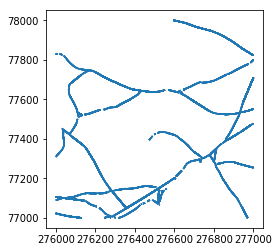

In [20]:
links_fid = range(1, len(geom_lines) + 1)
DPN_paths_links = gpd.GeoDataFrame({'fid': links_fid, 'startnode': start_node,
                                  'endnode': end_node, 'length': length, 'angle': angles,
                                  'climb_time_forward': climb_time_forward,'DPN' : dpn, 'geometry': geom_lines}, crs=27700)

DPN_paths_links['fid'] = 'dpn_' + DPN_paths_links['fid'].astype(str)

DPN_paths_links.plot()

(276173.784, 77746.295)
(276110.611, 77532.656)
LINESTRING (276173.784 77746.295, 276164.377 77743.52499999999)
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
LINESTRING (276164.377 77743.52499999999, 276152.644 77738.20699999999)
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
LINESTRING (276152.644 77738.20699999999, 276139.073 77730.52899999999)
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
LINESTRING (276139.073 77730.52899999999, 276129.211 77723.30100000001)
False


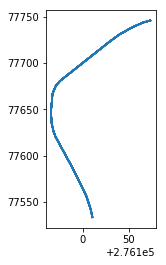

In [14]:
import shapely as shapely
from shapely.ops import split,snap
lines = []
if row1.geometry.geom_type != 'MultiLineString':
    points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
    line_2d = shapely.wkb.loads(shapely.wkb.dumps(row1.geometry, output_dimension=2))
    print(line_2d.coords[0])
    print(line_2d.coords[-1])
    union = points_2d.union(line_coords)
    union_coords = [Point(p.x,p.y) for p in union]
    #adding the points to the linestring
    line_coords = MultiPoint([Point(points) for points in line_2d.coords])
    points_coords = MultiPoint([Point(points) for points in points_2d.coords])

    first_point = line_coords[0]
    for points in line_coords[1:]:
        line = LineString([(first_point.x,first_point.y),(points.x,points.y)])
        #print(line)
        for intersecting_points in geom_points:
            intersect = line.within(intersecting_points)
            #intersect = line.intersection(Point(intersecting_points.x,intersecting_points.y))
            #print(intersect)
            lines.append(line)
        first_point = points


splitted_lines = gpd.GeoSeries(lines)
splitted_lines.plot()

In [1]:
    #line_coords_gpd = gpd.GeoDataFrame(geometry=line_coords)
    union = points_2d.union(line_coords)
    # converting points to linestring
    line = LineString(union)
    # Splitting the line based on where intersections
    splitted = split(line,points_2d)
    splitted.wkt
    for lin in splitted:
        lines.append(lin)
else:
    for linestring in row1.geometry:
        points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
        line_2d = shapely.wkb.loads(shapely.wkb.dumps(linestring, output_dimension=2))
        print(line_2d.coords[0])
        print(line_2d.coords[-1])
        #adding the points to the linestring
        line_coords = MultiPoint([Point(points) for points in line_2d.coords])
        #line_coords_gpd = gpd.GeoDataFrame(geometry=line_coords)
        union = points_2d.union(line_coords)
        # converting points to linestring
        line = LineString(union)
        # Splitting the line based on where intersections
        splitted = split(line,points_2d)
        splitted.wkt
        for lin in splitted:
            lines.append(lin)

splitted_lines = gpd.GeoSeries(lines)
splitted_lines.plot()

IndentationError: expected an indented block (2558004074.py, line 11)

In [ ]:
test_line = []
first_point = union[0]
for point in union[1:]:
    test_line.append(LineString([(first_point.x,first_point.y),(point.x,point.y)]))
    first_point = point
test_line[45]

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


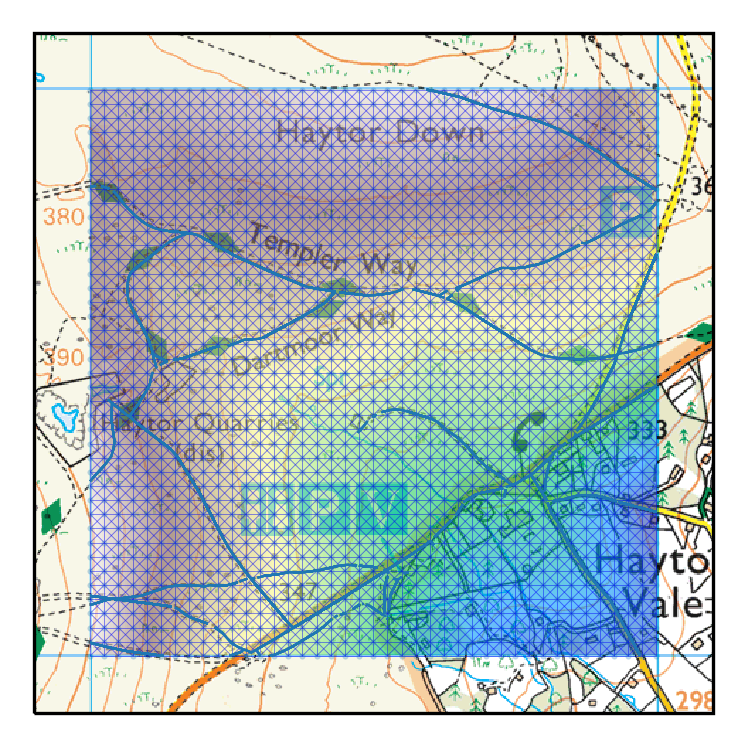

In [21]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                   cmap='terrain')
# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.3)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.3)

# displaying Detailed Path Network
#DPN_paths_nodes.plot(ax=ax,zorder=6,color='green',markersize=0.5)
# DPN_paths_nodes.plot(ax=ax,zorder = 5,markersize=0.2)
DPN_paths_links.plot(ax=ax,zorder = 4, linewidth=0.5)

display_extent = ((study_area_shapely.bounds[0] - 100, study_area_shapely.bounds[2] + 100,
                   study_area_shapely.bounds[1] - 100, study_area_shapely.bounds[3] + 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

In [22]:
DPN_paths_nodes.to_file("Study_area/SX7677/DPN_path_nodes.geojson", driver='GeoJSON',crs='EPSG:27700')
DPN_paths_links.to_file("Study_area/SX7677/DPN_path_links.geojson", driver='GeoJSON',crs='EPSG:27700')

In [17]:
def create_dpn_link(OSDPN_gpd,network_links):
    geom_points = []
    geom_lines = []
    start_node = []
    end_node = []
    height = []
    length = []
    angles = []
    climb_time_forward = []
    climb_time_backward = []
    dpn = []
    fid = []
    count = 1
    for index1,row1 in OSDPN_gpd.iterrows():
        if row1.geometry.geom_type != 'MultiLineString':
            intersects = {}
            local_height = []
            previous_point = 0
            start_point = Point(row1.geometry.coords[0])
            intersects[count]= start_point
            geom_points.append(start_point)
            height.append(start_point.z)
            local_height.append(start_point.z)
            start_point_fid = 'dpn_' + str(count)
            fid.append(start_point_fid)
            count = count + 1
            for index2, row2 in network_links.iterrows():
                intersecting_point = row1.geometry.intersection(row2.geometry)
                if not intersecting_point.is_empty:
                    if intersecting_point != previous_point:
                        network_node = [(Point(row2['geometry'].bounds[0],row2['geometry'].bounds[1])),(Point(row2['geometry'].bounds[2],row2['geometry'].bounds[3]))]
                        if intersecting_point.geom_type != 'MultiPoint':
                            intersects[count]= intersecting_point
                            geom_points.append(intersecting_point)
                            local_height.append(intersecting_point.z)
                            height.append(intersecting_point.z)
                            intersecting_point_fid = 'dpn_' + str(count)
                            fid.append(intersecting_point_fid)


                            #getting the points from the line
                            for node in network_node:

                                #getting fid values for forward direction
                                start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                                end_point = intersecting_point_fid
                                start_node.append(start_point)
                                end_node.append(end_point)

                                #get the reverse direction
                                start_node.append(end_point)
                                end_node.append(start_point)
                                ## get line geometry
                                line_forwards = LineString([(node.x,node.y),(intersecting_point.x,intersecting_point.y)])
                                line_backwards =LineString([(intersecting_point.x,intersecting_point.y),(node.x,node.y)])
                                geom_lines.append(line_forwards)
                                geom_lines.append(line_backwards)

                                # length
                                length.append(line_forwards.length)
                                length.append(line_backwards.length)

                                # get angle of elevation change and climb time
                                start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                                # print(start_height)
                                end_height_forward = start_height_backward = intersecting_point.z

                                # print(end_height)
                                if start_height_forward > end_height_forward:
                                    change_height = start_height_forward - end_height_forward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_forward - start_height_forward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_forwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                                if start_height_backward > end_height_backward:
                                    change_height = start_height_backward - end_height_backward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_backward - start_height_backward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_backwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                            count = count + 1
                        else:
                            for pt in intersecting_point:
                                intersects[count]=(Point(pt.x, pt.y,pt.z))
                                geom_points.append(Point(pt.x, pt.y,pt.z))
                                height.append(pt.z)
                                intersecting_point_fid = 'al+dpn_' + str(count)
                                fid.append(intersecting_point_fid)

                                #getting the points from the line

                                for node in network_node:

                                    #getting fid values for forward direction
                                    start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                                    end_point = intersecting_point_fid
                                    start_node.append(start_point)
                                    end_node.append(end_point)

                                    #get the reverse direction
                                    start_node.append(end_point)
                                    end_node.append(start_point)

                                    ## get line geometry
                                    line_forwards = LineString([(node.x,node.y),(pt.x,pt.y)])
                                    line_backwards =LineString([(pt.x,pt.y),(node.x,node.y)])
                                    geom_lines.append(line_forwards)
                                    geom_lines.append(line_backwards)

                                    # length
                                    length.append(line_forwards.length)
                                    length.append(line_backwards.length)

                                    # get angle of elevation change and climb time
                                    start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                                    # print(start_height)
                                    end_height_forward = start_height_backward = pt.z

                                    # print(end_height)
                                    if start_height_forward > end_height_forward:
                                        change_height = start_height_forward - end_height_forward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_forward - start_height_forward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / line_forwards.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(2)

                                    if start_height_backward > end_height_backward:
                                        change_height = start_height_backward - end_height_backward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_backward - start_height_backward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / line_backwards.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(2)

                                count = count + 1

                        previous_point = intersecting_point

            end_point = Point(row1.geometry.coords[-1])
            intersects[count]= end_point
            geom_points.append(end_point)
            height.append(end_point.z)
            local_height.append(end_point.z)
            start_point_fid = 'dpn_' + str(count)
            fid.append(start_point_fid)
            count = count + 1



            points = MultiPoint(list(intersects.values()))
            points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
            line_2d = shapely.wkb.loads(shapely.wkb.dumps(row1.geometry, output_dimension=2))
            intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
            intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
            #adding the points to the linestring
            line_coords = MultiPoint([Point(points) for points in line_2d.coords])
            union = points_2d.union(line_coords)
            # converting points to linestring
            line = LineString(union)
            # Splitting the line based on where intersections
            splitted = split(line,points_2d)
            for link in splitted:

                # get start and end node
                start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
                end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
                start_node.append('dpn_' + str(start_point))
                end_node.append( 'dpn_' + str(end_point))

                # get the reverse for backward direction
                start_node.append( 'dpn_' + str(end_point))
                end_node.append('dpn_' + str(start_point))

                # get line geometry
                geom_lines.append(link)
                reverse_link = substring(link,link.length,0)
                geom_lines.append(reverse_link)

                # length
                length.append(link.length)
                length.append(link.length)

                # get angle of elevation change and climb time
                start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
                # print(start_height)
                end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

                # print(end_height)
                if start_height_forward > end_height_forward:
                    change_height = start_height_forward - end_height_forward
                    climb_time_forward.append(0)
                else:
                    change_height = end_height_forward - start_height_forward
                    climb_time_forward.append(change_height / 10)

                # print(change_height)
                angle = degrees(atan((change_height / link.length)))
                # print(angle)
                angles.append(angle)
                dpn.append(1)

                if start_height_backward > end_height_backward:
                    change_height = start_height_backward - end_height_backward
                    climb_time_forward.append(0)
                else:
                    change_height = end_height_backward - start_height_backward
                    climb_time_forward.append(change_height / 10)

                # print(change_height)
                angle = degrees(atan((change_height / link.length)))
                # print(angle)
                angles.append(angle)
                dpn.append(1)
    else:



    DPN_paths_nodes = gpd.GeoDataFrame({'fid': fid,'height':height,'DPN': 1, 'geometry': geom_points},crs = 27700)

    links_fid = range(1, len(geom_lines) + 1)
    DPN_paths_links = gpd.GeoDataFrame({'fid': links_fid, 'startnode': start_node,
                                      'endnode': end_node, 'length': length, 'angle': angles,
                                      'climb_time_forward': climb_time_forward,'DPN' : dpn, 'geometry': geom_lines}, crs=27700)

    DPN_paths_links['fid'] = 'dpn_' + DPN_paths_links['fid'].astype(str)

    return DPN_paths_nodes,DPN_paths_links

DPN_paths_links, DPN_paths_nodes = create_dpn_link(OSDPN_gpd,network_links)

IndentationError: expected an indented block (3701117096.py, line 243)

## Not in a function for testing

In [ ]:
# 5659,16489,6637,14642,16558,
OSDPN_gpd = OSDPN_gpd.drop(16558)

In [15]:
geom_points = []
geom_lines = []
start_node = []
end_node = []
height = []
length = []
angles = []
climb_time_forward = []
climb_time_backward = []
dpn = []
fid = []
count = 1
for index1,row1 in OSDPN_gpd.iterrows():
    intersects = {}
    local_height = []
    previous_point = 0

    if row1.geometry.geom_type != 'MultiLineString':
        start_point = Point(row1.geometry.coords[0])
        intersects[count]= start_point
        geom_points.append(start_point)
        height.append(start_point.z)
        local_height.append(start_point.z)
        start_point_fid = 'dpn_' + str(count)
        fid.append(start_point_fid)
        count = count + 1
        for index2, row2 in network_links.iterrows():
            intersecting_point = row1.geometry.intersection(row2.geometry)
            if not intersecting_point.is_empty:
                if intersecting_point != previous_point:
                    network_node = [(Point(row2['geometry'].bounds[0],row2['geometry'].bounds[1])),(Point(row2['geometry'].bounds[2],row2['geometry'].bounds[3]))]
                    if intersecting_point.geom_type != 'MultiPoint':
                        intersects[count]= intersecting_point
                        geom_points.append(intersecting_point)
                        local_height.append(intersecting_point.z)
                        height.append(intersecting_point.z)
                        intersecting_point_fid = 'dpn_' + str(count)
                        fid.append(intersecting_point_fid)


                        #getting the points from the line
                        for node in network_node:

                            #getting fid values for forward direction
                            start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                            end_point = intersecting_point_fid
                            start_node.append(start_point)
                            end_node.append(end_point)

                            #get the reverse direction
                            start_node.append(end_point)
                            end_node.append(start_point)
                            ## get line geometry
                            line_forwards = LineString([(node.x,node.y),(intersecting_point.x,intersecting_point.y)])
                            line_backwards =LineString([(intersecting_point.x,intersecting_point.y),(node.x,node.y)])
                            geom_lines.append(line_forwards)
                            geom_lines.append(line_backwards)

                            # length
                            length.append(line_forwards.length)
                            length.append(line_backwards.length)

                            # get angle of elevation change and climb time
                            start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                            # print(start_height)
                            end_height_forward = start_height_backward = intersecting_point.z

                            # print(end_height)
                            if start_height_forward > end_height_forward:
                                change_height = start_height_forward - end_height_forward
                                climb_time_forward.append(0)
                            else:
                                change_height = end_height_forward - start_height_forward
                                climb_time_forward.append(change_height / 10)

                            # print(change_height)
                            angle = degrees(atan((change_height / line_forwards.length)))
                            # print(angle)
                            angles.append(angle)
                            dpn.append(2)

                            if start_height_backward > end_height_backward:
                                change_height = start_height_backward - end_height_backward
                                climb_time_forward.append(0)
                            else:
                                change_height = end_height_backward - start_height_backward
                                climb_time_forward.append(change_height / 10)

                            # print(change_height)
                            angle = degrees(atan((change_height / line_backwards.length)))
                            # print(angle)
                            angles.append(angle)
                            dpn.append(2)

                        count = count + 1
                    else:
                        for pt in intersecting_point:
                            intersects[count]=(Point(pt.x, pt.y,pt.z))
                            geom_points.append(Point(pt.x, pt.y,pt.z))
                            height.append(pt.z)
                            local_height.append(pt.z)
                            intersecting_point_fid = 'al+dpn_' + str(count)
                            fid.append(intersecting_point_fid)

                            #getting the points from the line

                            for node in network_node:

                                #getting fid values for forward direction
                                start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                                end_point = intersecting_point_fid
                                start_node.append(start_point)
                                end_node.append(end_point)

                                #get the reverse direction
                                start_node.append(end_point)
                                end_node.append(start_point)

                                ## get line geometry
                                line_forwards = LineString([(node.x,node.y),(pt.x,pt.y)])
                                line_backwards =LineString([(pt.x,pt.y),(node.x,node.y)])
                                geom_lines.append(line_forwards)
                                geom_lines.append(line_backwards)

                                # length
                                length.append(line_forwards.length)
                                length.append(line_backwards.length)

                                # get angle of elevation change and climb time
                                start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                                # print(start_height)
                                end_height_forward = start_height_backward = pt.z

                                # print(end_height)
                                if start_height_forward > end_height_forward:
                                    change_height = start_height_forward - end_height_forward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_forward - start_height_forward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_forwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                                if start_height_backward > end_height_backward:
                                    change_height = start_height_backward - end_height_backward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_backward - start_height_backward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_backwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                            count = count + 1

                    previous_point = intersecting_point

        end_point = Point(row1.geometry.coords[-1])
        intersects[count]= end_point
        geom_points.append(end_point)
        height.append(end_point.z)
        local_height.append(end_point.z)
        start_point_fid = 'dpn_' + str(count)
        fid.append(start_point_fid)
        count = count + 1



        points = MultiPoint(list(intersects.values()))
        points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
        line_2d = shapely.wkb.loads(shapely.wkb.dumps(row1.geometry, output_dimension=2))
        intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
        intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
        #adding the points to the linestring
        line_coords = MultiPoint([Point(points) for points in line_2d.coords])
        union = points_2d.union(line_coords)
        # converting points to linestring
        line = LineString(union)
        # Splitting the line based on where intersections
        splitted = split(line,points_2d)
        for link in splitted:

            # get start and end node
            start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
            end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
            start_node.append('dpn_' + str(start_point))
            end_node.append( 'dpn_' + str(end_point))

            # get the reverse for backward direction
            start_node.append( 'dpn_' + str(end_point))
            end_node.append('dpn_' + str(start_point))

            # get line geometry
            geom_lines.append(link)
            reverse_link = substring(link,link.length,0)
            geom_lines.append(reverse_link)

            # length
            length.append(link.length)
            length.append(link.length)

            # get angle of elevation change and climb time
            start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
            # print(start_height)
            end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

            # print(end_height)
            if start_height_forward > end_height_forward:
                change_height = start_height_forward - end_height_forward
                climb_time_forward.append(0)
            else:
                change_height = end_height_forward - start_height_forward
                climb_time_forward.append(change_height / 10)

            # print(change_height)
            angle = degrees(atan((change_height / link.length)))
            # print(angle)
            angles.append(angle)
            dpn.append(1)

            if start_height_backward > end_height_backward:
                change_height = start_height_backward - end_height_backward
                climb_time_forward.append(0)
            else:
                change_height = end_height_backward - start_height_backward
                climb_time_forward.append(change_height / 10)

            # print(change_height)
            angle = degrees(atan((change_height / link.length)))
            # print(angle)
            angles.append(angle)
            dpn.append(1)
    else:
        for linestring in row1.geometry:
            start_point = Point(linestring.coords[0])
            intersects[count]= start_point
            geom_points.append(start_point)
            height.append(start_point.z)
            local_height.append(start_point.z)
            start_point_fid = 'dpn_' + str(count)
            fid.append(start_point_fid)
            count = count + 1
            for index2, row2 in network_links.iterrows():
                intersecting_point = row1.geometry.intersection(row2.geometry)
                if not intersecting_point.is_empty:
                    if intersecting_point != previous_point:
                        network_node = [(Point(row2['geometry'].bounds[0],row2['geometry'].bounds[1])),(Point(row2['geometry'].bounds[2],row2['geometry'].bounds[3]))]
                        if intersecting_point.geom_type != 'MultiPoint':
                            intersects[count]= intersecting_point
                            geom_points.append(intersecting_point)
                            local_height.append(intersecting_point.z)
                            height.append(intersecting_point.z)
                            intersecting_point_fid = 'dpn_' + str(count)
                            fid.append(intersecting_point_fid)


                            #getting the points from the line
                            for node in network_node:

                                #getting fid values for forward direction
                                start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                                end_point = intersecting_point_fid
                                start_node.append(start_point)
                                end_node.append(end_point)

                                #get the reverse direction
                                start_node.append(end_point)
                                end_node.append(start_point)
                                ## get line geometry
                                line_forwards = LineString([(node.x,node.y),(intersecting_point.x,intersecting_point.y)])
                                line_backwards =LineString([(intersecting_point.x,intersecting_point.y),(node.x,node.y)])
                                geom_lines.append(line_forwards)
                                geom_lines.append(line_backwards)

                                # length
                                length.append(line_forwards.length)
                                length.append(line_backwards.length)

                                # get angle of elevation change and climb time
                                start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                                # print(start_height)
                                end_height_forward = start_height_backward = intersecting_point.z

                                # print(end_height)
                                if start_height_forward > end_height_forward:
                                    change_height = start_height_forward - end_height_forward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_forward - start_height_forward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_forwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                                if start_height_backward > end_height_backward:
                                    change_height = start_height_backward - end_height_backward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_backward - start_height_backward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_backwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                            count = count + 1
                        else:
                            for pt in intersecting_point:
                                intersects[count]=(Point(pt.x, pt.y,pt.z))
                                geom_points.append(Point(pt.x, pt.y,pt.z))
                                height.append(pt.z)
                                local_height.append(pt.z)
                                intersecting_point_fid = 'al+dpn_' + str(count)
                                fid.append(intersecting_point_fid)

                                #getting the points from the line

                                for node in network_node:

                                    #getting fid values for forward direction
                                    start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                                    end_point = intersecting_point_fid
                                    start_node.append(start_point)
                                    end_node.append(end_point)

                                    #get the reverse direction
                                    start_node.append(end_point)
                                    end_node.append(start_point)

                                    ## get line geometry
                                    line_forwards = LineString([(node.x,node.y),(pt.x,pt.y)])
                                    line_backwards =LineString([(pt.x,pt.y),(node.x,node.y)])
                                    geom_lines.append(line_forwards)
                                    geom_lines.append(line_backwards)

                                    # length
                                    length.append(line_forwards.length)
                                    length.append(line_backwards.length)

                                    # get angle of elevation change and climb time
                                    start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                                    # print(start_height)
                                    end_height_forward = start_height_backward = pt.z

                                    # print(end_height)
                                    if start_height_forward > end_height_forward:
                                        change_height = start_height_forward - end_height_forward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_forward - start_height_forward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / line_forwards.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(2)

                                    if start_height_backward > end_height_backward:
                                        change_height = start_height_backward - end_height_backward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_backward - start_height_backward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / line_backwards.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(2)

                                count = count + 1

                        previous_point = intersecting_point

            end_point = Point(linestring.coords[-1])
            intersects[count]= end_point
            geom_points.append(end_point)
            height.append(end_point.z)
            local_height.append(end_point.z)
            start_point_fid = 'dpn_' + str(count)
            fid.append(start_point_fid)
            count = count + 1




            points = MultiPoint(list(intersects.values()))
            points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
            line_2d = shapely.wkb.loads(shapely.wkb.dumps(linestring, output_dimension=2))
            intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
            intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
            #adding the points to the linestring
            line_coords = MultiPoint([Point(points) for points in line_2d.coords])
            union = points_2d.union(line_coords)
            # converting points to linestring
            line = LineString(union)
            # Splitting the line based on where intersections
            splitted = split(line,points_2d)
            for link in splitted:

                # get start and end node
                start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
                end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
                start_node.append('dpn_' + str(start_point))
                end_node.append( 'dpn_' + str(end_point))

                # get the reverse for backward direction
                start_node.append( 'dpn_' + str(end_point))
                end_node.append('dpn_' + str(start_point))

                # get line geometry
                geom_lines.append(link)
                reverse_link = substring(link,link.length,0)
                geom_lines.append(reverse_link)

                # length
                length.append(link.length)
                length.append(link.length)

                # get angle of elevation change and climb time
                start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
                # print(start_height)
                end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

                # print(end_height)
                if start_height_forward > end_height_forward:
                    change_height = start_height_forward - end_height_forward
                    climb_time_forward.append(0)
                else:
                    change_height = end_height_forward - start_height_forward
                    climb_time_forward.append(change_height / 10)

                # print(change_height)
                angle = degrees(atan((change_height / link.length)))
                # print(angle)
                angles.append(angle)
                dpn.append(1)

                if start_height_backward > end_height_backward:
                    change_height = start_height_backward - end_height_backward
                    climb_time_forward.append(0)
                else:
                    change_height = end_height_backward - start_height_backward
                    climb_time_forward.append(change_height / 10)

                # print(change_height)
                angle = degrees(atan((change_height / link.length)))
                # print(angle)
                angles.append(angle)
                dpn.append(1)

DPN_paths_nodes = gpd.GeoDataFrame({'fid': fid,'height':height,'DPN': 1, 'geometry': geom_points},crs = 27700)

links_fid = range(1, len(geom_lines) + 1)
DPN_paths_links = gpd.GeoDataFrame({'fid': links_fid, 'startnode': start_node,
                                  'endnode': end_node, 'length': length, 'angle': angles,
                                  'climb_time_forward': climb_time_forward,'DPN' : dpn, 'geometry': geom_lines}, crs=27700)

DPN_paths_links['fid'] = 'dpn_' + DPN_paths_links['fid'].astype(str)

KeyboardInterrupt: 

In [ ]:
DPN_paths_nodes.plot()

In [ ]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                   cmap='terrain')
# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.3)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.3)

#
#DPN_paths_nodes.plot(ax=ax,zorder = 5,markersize=0.2)
OSDPN_gpd_not_working.plot(ax=ax,zorder = 4, linewidth=0.5,edgecolor='red')
DPN_paths_links.plot(ax=ax,zorder = 4, linewidth=0.5,edgecolor='green')

display_extent = ((study_area_shapely.bounds[0]- 100, study_area_shapely.bounds[2]+ 100,
                       study_area_shapely.bounds[1]- 100, study_area_shapely.bounds[3]+ 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()


In [28]:
geom_points = []
geom_lines = []
start_node = []
end_node = []
height = []
length = []
angles = []
climb_time_forward = []
climb_time_backward = []
dpn = []
fid = []
count = 1
for index1,row1 in OSDPN_gpd.iterrows():
    intersects = {}
    local_height = []
    previous_point = 0

    if row1.geometry.geom_type != 'MultiLineString':
        start_point = Point(row1.geometry.coords[0])
        intersects[count]= start_point
        geom_points.append(start_point)
        height.append(start_point.z)
        local_height.append(start_point.z)
        start_point_fid = 'dpn_' + str(count)
        fid.append(start_point_fid)
        count = count + 1
        for index2, row2 in network_links.iterrows():
            intersecting_point = row1.geometry.intersection(row2.geometry)
            if not intersecting_point.is_empty:
                if intersecting_point != previous_point:
                    network_node = [(Point(row2['geometry'].bounds[0],row2['geometry'].bounds[1])),(Point(row2['geometry'].bounds[2],row2['geometry'].bounds[3]))]
                    if intersecting_point.geom_type != 'MultiPoint':
                        intersects[count]= intersecting_point
                        geom_points.append(intersecting_point)
                        local_height.append(intersecting_point.z)
                        height.append(intersecting_point.z)
                        intersecting_point_fid = 'dpn_' + str(count)
                        fid.append(intersecting_point_fid)


                        #getting the points from the line
                        for node in network_node:

                            #getting fid values for forward direction
                            start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                            end_point = intersecting_point_fid
                            start_node.append(start_point)
                            end_node.append(end_point)

                            #get the reverse direction
                            start_node.append(end_point)
                            end_node.append(start_point)
                            ## get line geometry
                            line_forwards = LineString([(node.x,node.y),(intersecting_point.x,intersecting_point.y)])
                            line_backwards =LineString([(intersecting_point.x,intersecting_point.y),(node.x,node.y)])
                            geom_lines.append(line_forwards)
                            geom_lines.append(line_backwards)

                            # length
                            length.append(line_forwards.length)
                            length.append(line_backwards.length)

                            # get angle of elevation change and climb time
                            start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                            # print(start_height)
                            end_height_forward = start_height_backward = intersecting_point.z

                            # print(end_height)
                            if start_height_forward > end_height_forward:
                                change_height = start_height_forward - end_height_forward
                                climb_time_forward.append(0)
                            else:
                                change_height = end_height_forward - start_height_forward
                                climb_time_forward.append(change_height / 10)

                            # print(change_height)
                            angle = degrees(atan((change_height / line_forwards.length)))
                            # print(angle)
                            angles.append(angle)
                            dpn.append(2)

                            if start_height_backward > end_height_backward:
                                change_height = start_height_backward - end_height_backward
                                climb_time_forward.append(0)
                            else:
                                change_height = end_height_backward - start_height_backward
                                climb_time_forward.append(change_height / 10)

                            # print(change_height)
                            angle = degrees(atan((change_height / line_backwards.length)))
                            # print(angle)
                            angles.append(angle)
                            dpn.append(2)

                        count = count + 1
                    else:
                        for pt in intersecting_point:
                            intersects[count]=(Point(pt.x, pt.y,pt.z))
                            geom_points.append(Point(pt.x, pt.y,pt.z))
                            height.append(pt.z)
                            local_height.append(pt.z)
                            intersecting_point_fid = 'al+dpn_' + str(count)
                            fid.append(intersecting_point_fid)

                            #getting the points from the line

                            for node in network_node:

                                #getting fid values for forward direction
                                start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                                end_point = intersecting_point_fid
                                start_node.append(start_point)
                                end_node.append(end_point)

                                #get the reverse direction
                                start_node.append(end_point)
                                end_node.append(start_point)

                                ## get line geometry
                                line_forwards = LineString([(node.x,node.y),(pt.x,pt.y)])
                                line_backwards =LineString([(pt.x,pt.y),(node.x,node.y)])
                                geom_lines.append(line_forwards)
                                geom_lines.append(line_backwards)

                                # length
                                length.append(line_forwards.length)
                                length.append(line_backwards.length)

                                # get angle of elevation change and climb time
                                start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                                # print(start_height)
                                end_height_forward = start_height_backward = pt.z

                                # print(end_height)
                                if start_height_forward > end_height_forward:
                                    change_height = start_height_forward - end_height_forward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_forward - start_height_forward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_forwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                                if start_height_backward > end_height_backward:
                                    change_height = start_height_backward - end_height_backward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_backward - start_height_backward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_backwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                            count = count + 1

                    previous_point = intersecting_point

        end_point = Point(row1.geometry.coords[-1])
        intersects[count]= end_point
        geom_points.append(end_point)
        height.append(end_point.z)
        local_height.append(end_point.z)
        start_point_fid = 'dpn_' + str(count)
        fid.append(start_point_fid)
        count = count + 1



        points = MultiPoint(list(intersects.values()))
        points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
        line_2d = shapely.wkb.loads(shapely.wkb.dumps(row1.geometry, output_dimension=2))
        intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
        intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
        #adding the points to the linestring
        line_coords = MultiPoint([Point(points) for points in line_2d.coords])
        union = points_2d.union(line_coords)
        # converting points to linestring
        line = LineString(union)
        # Splitting the line based on where intersections
        splitted = split(line,points_2d)
        for link in splitted:

            # get start and end node
            start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
            end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
            start_node.append('dpn_' + str(start_point))
            end_node.append( 'dpn_' + str(end_point))

            # get the reverse for backward direction
            start_node.append( 'dpn_' + str(end_point))
            end_node.append('dpn_' + str(start_point))

            # get line geometry
            geom_lines.append(link)
            reverse_link = substring(link,link.length,0)
            geom_lines.append(reverse_link)

            # length
            length.append(link.length)
            length.append(link.length)

            # get angle of elevation change and climb time
            start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
            # print(start_height)
            end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

            # print(end_height)
            if start_height_forward > end_height_forward:
                change_height = start_height_forward - end_height_forward
                climb_time_forward.append(0)
            else:
                change_height = end_height_forward - start_height_forward
                climb_time_forward.append(change_height / 10)

            # print(change_height)
            angle = degrees(atan((change_height / link.length)))
            # print(angle)
            angles.append(angle)
            dpn.append(1)

            if start_height_backward > end_height_backward:
                change_height = start_height_backward - end_height_backward
                climb_time_forward.append(0)
            else:
                change_height = end_height_backward - start_height_backward
                climb_time_forward.append(change_height / 10)

            # print(change_height)
            angle = degrees(atan((change_height / link.length)))
            # print(angle)
            angles.append(angle)
            dpn.append(1)
    else:
        for linestring in row1.geometry:
            start_point = Point(linestring.coords[0])
            intersects[count]= start_point
            geom_points.append(start_point)
            height.append(start_point.z)
            local_height.append(start_point.z)
            start_point_fid = 'dpn_' + str(count)
            fid.append(start_point_fid)
            count = count + 1
            for index2, row2 in network_links.iterrows():
                intersecting_point = row1.geometry.intersection(row2.geometry)
                if not intersecting_point.is_empty:
                    if intersecting_point != previous_point:
                        network_node = [(Point(row2['geometry'].bounds[0],row2['geometry'].bounds[1])),(Point(row2['geometry'].bounds[2],row2['geometry'].bounds[3]))]
                        if intersecting_point.geom_type != 'MultiPoint':
                            intersects[count]= intersecting_point
                            geom_points.append(intersecting_point)
                            local_height.append(intersecting_point.z)
                            height.append(intersecting_point.z)
                            intersecting_point_fid = 'dpn_' + str(count)
                            fid.append(intersecting_point_fid)


                            #getting the points from the line
                            for node in network_node:

                                #getting fid values for forward direction
                                start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                                end_point = intersecting_point_fid
                                start_node.append(start_point)
                                end_node.append(end_point)

                                #get the reverse direction
                                start_node.append(end_point)
                                end_node.append(start_point)
                                ## get line geometry
                                line_forwards = LineString([(node.x,node.y),(intersecting_point.x,intersecting_point.y)])
                                line_backwards =LineString([(intersecting_point.x,intersecting_point.y),(node.x,node.y)])
                                geom_lines.append(line_forwards)
                                geom_lines.append(line_backwards)

                                # length
                                length.append(line_forwards.length)
                                length.append(line_backwards.length)

                                # get angle of elevation change and climb time
                                start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                                # print(start_height)
                                end_height_forward = start_height_backward = intersecting_point.z

                                # print(end_height)
                                if start_height_forward > end_height_forward:
                                    change_height = start_height_forward - end_height_forward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_forward - start_height_forward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_forwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                                if start_height_backward > end_height_backward:
                                    change_height = start_height_backward - end_height_backward
                                    climb_time_forward.append(0)
                                else:
                                    change_height = end_height_backward - start_height_backward
                                    climb_time_forward.append(change_height / 10)

                                # print(change_height)
                                angle = degrees(atan((change_height / line_backwards.length)))
                                # print(angle)
                                angles.append(angle)
                                dpn.append(2)

                            count = count + 1
                        else:
                            for pt in intersecting_point:
                                intersects[count]=(Point(pt.x, pt.y,pt.z))
                                geom_points.append(Point(pt.x, pt.y,pt.z))
                                height.append(pt.z)
                                local_height.append(pt.z)
                                intersecting_point_fid = 'al+dpn_' + str(count)
                                fid.append(intersecting_point_fid)

                                #getting the points from the line

                                for node in network_node:

                                    #getting fid values for forward direction
                                    start_point = network_nodes.loc[network_nodes['geometry']== node,'fid'].iloc[0]
                                    end_point = intersecting_point_fid
                                    start_node.append(start_point)
                                    end_node.append(end_point)

                                    #get the reverse direction
                                    start_node.append(end_point)
                                    end_node.append(start_point)

                                    ## get line geometry
                                    line_forwards = LineString([(node.x,node.y),(pt.x,pt.y)])
                                    line_backwards =LineString([(pt.x,pt.y),(node.x,node.y)])
                                    geom_lines.append(line_forwards)
                                    geom_lines.append(line_backwards)

                                    # length
                                    length.append(line_forwards.length)
                                    length.append(line_backwards.length)

                                    # get angle of elevation change and climb time
                                    start_height_forward = end_height_backward =  network_nodes.loc[network_nodes['geometry']== node,'height'].iloc[0]
                                    # print(start_height)
                                    end_height_forward = start_height_backward = pt.z

                                    # print(end_height)
                                    if start_height_forward > end_height_forward:
                                        change_height = start_height_forward - end_height_forward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_forward - start_height_forward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / line_forwards.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(2)

                                    if start_height_backward > end_height_backward:
                                        change_height = start_height_backward - end_height_backward
                                        climb_time_forward.append(0)
                                    else:
                                        change_height = end_height_backward - start_height_backward
                                        climb_time_forward.append(change_height / 10)

                                    # print(change_height)
                                    angle = degrees(atan((change_height / line_backwards.length)))
                                    # print(angle)
                                    angles.append(angle)
                                    dpn.append(2)

                                count = count + 1

                        previous_point = intersecting_point

            end_point = Point(linestring.coords[-1])
            intersects[count]= end_point
            geom_points.append(end_point)
            height.append(end_point.z)
            local_height.append(end_point.z)
            start_point_fid = 'dpn_' + str(count)
            fid.append(start_point_fid)
            count = count + 1




            points = MultiPoint(list(intersects.values()))
            points_2d = shapely.wkb.loads(shapely.wkb.dumps(points, output_dimension=2))
            line_2d = shapely.wkb.loads(shapely.wkb.dumps(linestring, output_dimension=2))
            intersecting_points_2d = [Point(p.x,p.y) for p in points_2d]
            intersects_gpd = gpd.GeoDataFrame({'fid':(list(intersects.keys())),'height':local_height,'geometry':intersecting_points_2d})
            #adding the points to the linestring
            line_coords = MultiPoint([Point(points) for points in line_2d.coords])
            union = points_2d.union(line_coords)
            # converting points to linestring
            line = LineString(union)
            # Splitting the line based on where intersections
            splitted = split(line,points_2d)
            for link in splitted:

                # get start and end node
                start_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'fid'].iloc[0]
                end_point = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'fid'].iloc[0]
                start_node.append('dpn_' + str(start_point))
                end_node.append( 'dpn_' + str(end_point))

                # get the reverse for backward direction
                start_node.append( 'dpn_' + str(end_point))
                end_node.append('dpn_' + str(start_point))

                # get line geometry
                geom_lines.append(link)
                reverse_link = substring(link,link.length,0)
                geom_lines.append(reverse_link)

                # length
                length.append(link.length)
                length.append(link.length)

                # get angle of elevation change and climb time
                start_height_forward = end_height_backward =  intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[0]),'height'].iloc[0]
                # print(start_height)
                end_height_forward = start_height_backward = intersects_gpd.loc[intersects_gpd['geometry']== Point(link.coords[-1]),'height'].iloc[0]

                # print(end_height)
                if start_height_forward > end_height_forward:
                    change_height = start_height_forward - end_height_forward
                    climb_time_forward.append(0)
                else:
                    change_height = end_height_forward - start_height_forward
                    climb_time_forward.append(change_height / 10)

                # print(change_height)
                angle = degrees(atan((change_height / link.length)))
                # print(angle)
                angles.append(angle)
                dpn.append(1)

                if start_height_backward > end_height_backward:
                    change_height = start_height_backward - end_height_backward
                    climb_time_forward.append(0)
                else:
                    change_height = end_height_backward - start_height_backward
                    climb_time_forward.append(change_height / 10)

                # print(change_height)
                angle = degrees(atan((change_height / link.length)))
                # print(angle)
                angles.append(angle)
                dpn.append(1)

DPN_paths_nodes = gpd.GeoDataFrame({'fid': fid,'height':height,'DPN': 1, 'geometry': geom_points},crs = 27700)

links_fid = range(1, len(geom_lines) + 1)
DPN_paths_links = gpd.GeoDataFrame({'fid': links_fid, 'startnode': start_node,
                                  'endnode': end_node, 'length': length, 'angle': angles,
                                  'climb_time_forward': climb_time_forward,'DPN' : dpn, 'geometry': geom_lines}, crs=27700)

DPN_paths_links['fid'] = 'dpn_' + DPN_paths_links['fid'].astype(str)

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


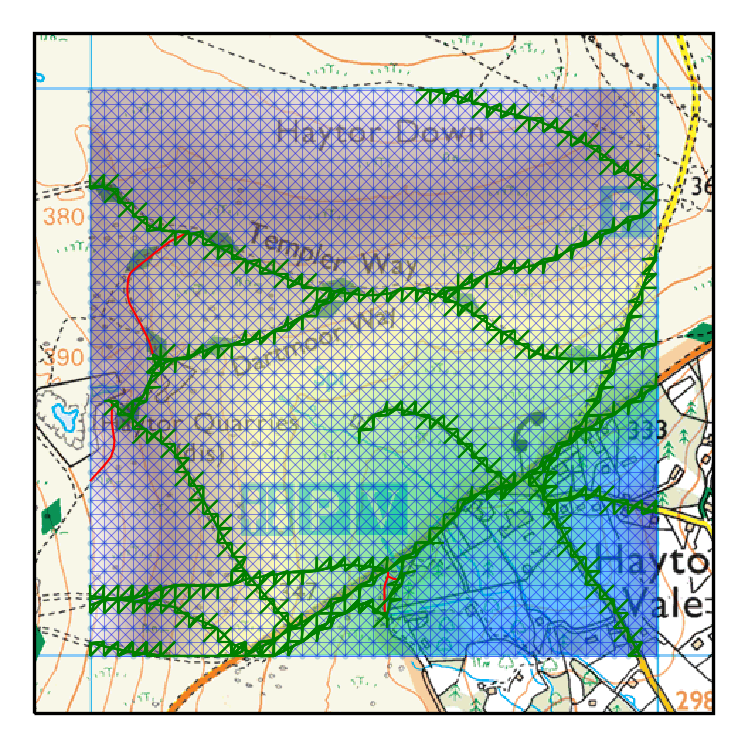

In [35]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                   cmap='terrain')
# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.3)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.3)

#
#DPN_paths_nodes.plot(ax=ax,zorder = 5,markersize=0.2)
OSDPN_gpd_not_working.plot(ax=ax,zorder = 4, linewidth=0.5,edgecolor='red')
DPN_paths_links.plot(ax=ax,zorder = 4, linewidth=0.5,edgecolor='green')

display_extent = ((study_area_shapely.bounds[0]- 100, study_area_shapely.bounds[2]+ 100,
                       study_area_shapely.bounds[1]- 100, study_area_shapely.bounds[3]+ 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()
